# AirBnB guest arrival prediction using tree-based methods



<b><div style="text-align: right">[TOTAL POINTS: 10]</div></b>

The assignment is divided into three different levels: Level1, Level2, and Level3.

## Learning Objective(Level 1)

<b><div style="text-align: right">[POINTS: 4]</div></b>

By the end of this assignment, a student should be able to

- Apply necessary preprocessing steps on the data to make it suitable for training.

- Train Bagging Classifier, Random Forest Classifier, XGBoost Classifier.

- Fine-tune and monitor the performance of XGBoost.



Let's start with the problem description of level1.
In this assignment, you will train different ensemble models to predict whether the customer will cancel the booking or not. For a tourism-based country like Nepal, hospitality is a major source of income. The given data represents booking information made by foreign customers via AirBnB for the year 2018. Your task in level1 is to use this data to predict whether the customer will cancel the booking or not.


## Dataset Description:

The dataset, **AirBnB customer arrival prediction**, contains information regarding booking in the hotel, and includes features like such as meal, arrival date(date of booking), car parking space in hotel, etc. All features are listed below.

Note: The given dataset is a modification of [Hotel booking demand datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191) collected by **Nuano et al.** and is availabe under [Creative Commons 4.0](https://creativecommons.org/licenses/by/4.0/).

**Number of Instances:** 119,386 \
**Number of Attributes:** 25 **Input Features** + 1 **Target**(__is_canceled__)

### Attribute Information:
The detail information of each attribute is listed as:

* **hotel** - Type of hotel resort or city
* **is_canceled** - The label column. This indicates whether the guests canceled their booking or they checked-in
* **lead_time** - Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
* **arrival_date_year** - year of the arrival date
* **arrival_date_month** - Month of arrival date with 12 categories: “January” to “December” expressed in numbers. 1 indicates January, and 12 indicate December. 
* **arrival_date_week_number** - Week number of the arrival date
* **arrival_date_day_of_month** - Day of the month of the arrival date
* **stays_in_weekend_nights** - Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel.
* **stays_in_week_nights** - Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
* **meal** - Type of meal booked. 
* **country** - Country of origin. Categories are represented in the ISO 3155–3:2013 format
* **market_segment** - Market segment designation. In categories, the term "TA" means "Travel Agents" and "TO" means "Tour Operators"
* **distribution_channel** - Booking distribution channel. The term "TA" means "Travel Agents" and "TO" means "Tour Operators"
* **is_repeated_guest** - Value indicating if the booking name was from a repeated guest (1) or not (0)
* **reserved_room_type** - Code of room type reserved. 
* **assigned_room_type** - Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g., overbooking) or by customer request.
* **booking_changes** - Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
* **deposit_type** - Indication on if the customer deposited to guarantee the booking.
* **agent** - ID of the travel agency that made the booking
* **days_in_waiting_list** - Number of days the booking was on the waiting list before it was confirmed to the customer. 
* **customer_type** - Type of booking. One of Contract, Group, Transient, and Transient-party.
* **adr** - Average Daily Rate
* **required_car_parking_spaces** - Number of car parking spaces required by the customer.
* **total_of_special_requests** - Number of special requests made by the customer (e.g. twin bed or high floor)
* **total_guests** - Total number of guests(includes adults, children, and babies)
* **net_booking_cancelled** - A difference between the total number of the previous booking canceled and the previous booking not canceled before this booking. A positive value means that the customer did not cancel most of the previous booking.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

RANDOM_STATE = 7
np.random.seed(RANDOM_STATE)

### Load csv file

In [2]:
df= pd.read_csv("https://storage.googleapis.com/codehub-data/1-lv2-3-airbnb-guest-arrival.csv", index_col = 0)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,country,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_guests,net_booking_cancelled
0,Resort Hotel,0,342,2015,July,27,1,0,0,NaN,PRT,Direct,Direct,0,C,NaN,3,No Deposit,NaN,0,Transient,0.0,0,0,2.0,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,BB,PRT,Direct,Direct,0,C,C,4,No Deposit,NaN,0,Transient,0.0,0,0,2.0,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,BB,GBR,Direct,Direct,0,A,C,0,No Deposit,NaN,0,Transient,75.0,0,0,1.0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,NaN,GBR,Corporate,NaN,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,1.0,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,BB,GBR,Online TA,TA/TO,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,2.0,0


## Preprocessing
### Identification of features with missing values
Let's find out if the columns in our dataset has any misssing values.

In [3]:
df.isnull().sum()

hotel                              0
is_canceled                        0
lead_time                          0
arrival_date_year                  0
arrival_date_month                 0
arrival_date_week_number           0
arrival_date_day_of_month          0
stays_in_weekend_nights            0
stays_in_week_nights               0
meal                           11939
country                          488
market_segment                     0
distribution_channel           11939
is_repeated_guest                  0
reserved_room_type                 0
assigned_room_type             11939
booking_changes                    0
deposit_type                       0
agent                          16340
days_in_waiting_list               0
customer_type                      0
adr                                0
required_car_parking_spaces        0
total_of_special_requests          0
total_guests                       4
net_booking_cancelled              0
dtype: int64

We can see that columns `agent`, `assigned_room_type`, `distribution_channel`, `meal`, `country`, and `total_guests` have missing values.

Since only four instances in the column `total_guests` have missing value, we will drop them.

In [4]:
# removing all rows that have missing values in total_guests column
df.dropna(how='any', subset=['total_guests'], inplace=True)

We will impute rest of the features with mode.

In [5]:
missing_features = ['agent', 'assigned_room_type', 'distribution_channel', 'meal', 'country']
for feature in missing_features:
    df[feature].fillna(df[feature].mode()[0], inplace = True)

Until now, we have imputed all the missing values in the dataset.

### Feature generation

Here we will combine features `arrival_date_month` and `arrival_date_year` to generate a new feature `month`.

In [6]:
df['arrival_date_year'].unique()

array([2015, 2016, 2017])

In [7]:
df['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In the feature `month`,  we will consider Jan, 2015 as 0, Feb, 2015 as 1, and so on. So this feature will represent the month number starting from Jan, 2015.

In [8]:
replace_year = {2015:0, 2016: 12, 2017:24}
replace_month= {'Januray':0, 'February': 1, 'March': 2, 'April': 3, 'May': 4, 'June': 5, 'July': 6, 'August': 7, 'September': 8, 'October': 9, 'November': 10, 'December': 11}

In [9]:
df['arrival_date_year'] = df['arrival_date_year'].replace(replace_year)
df['arrival_date_month'] = df['arrival_date_month'].replace(replace_month)
df['month'] = df['arrival_date_year']+df['arrival_date_year']
# df.drop(['arrival_date_year', 'arrival_date_year'], axis = 1, inplace = True)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,country,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_guests,net_booking_cancelled,month
0,Resort Hotel,0,342,0,6,27,1,0,0,BB,PRT,Direct,Direct,0,C,A,3,No Deposit,9.0,0,Transient,0.0,0,0,2.0,0,0
1,Resort Hotel,0,737,0,6,27,1,0,0,BB,PRT,Direct,Direct,0,C,C,4,No Deposit,9.0,0,Transient,0.0,0,0,2.0,0,0
2,Resort Hotel,0,7,0,6,27,1,0,1,BB,GBR,Direct,Direct,0,A,C,0,No Deposit,9.0,0,Transient,75.0,0,0,1.0,0,0
3,Resort Hotel,0,13,0,6,27,1,0,1,BB,GBR,Corporate,TA/TO,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,1.0,0,0
4,Resort Hotel,0,14,0,6,27,1,0,2,BB,GBR,Online TA,TA/TO,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,2.0,0,0


### Label Encoding

All categorical features are encoded with label encoding.


In [10]:
from sklearn.preprocessing import LabelEncoder


cat_vars = [var for var in df.columns if df[var].dtypes=='O']
df[cat_vars] = df[cat_vars].astype(str).apply(LabelEncoder().fit_transform)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,country,market_segment,distribution_channel,is_repeated_guest,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_guests,net_booking_cancelled,month
0,1,0,342,0,7,27,1,0,0,0,135,3,1,0,2,0,3,0,9.0,0,2,0.0,0,0,2.0,0,0
1,1,0,737,0,7,27,1,0,0,0,135,3,1,0,2,2,4,0,9.0,0,2,0.0,0,0,2.0,0,0
2,1,0,7,0,7,27,1,0,1,0,59,3,1,0,0,2,0,0,9.0,0,2,75.0,0,0,1.0,0,0
3,1,0,13,0,7,27,1,0,1,0,59,2,3,0,0,0,0,0,304.0,0,2,75.0,0,0,1.0,0,0
4,1,0,14,0,7,27,1,0,2,0,59,6,3,0,0,0,0,0,240.0,0,2,98.0,0,1,2.0,0,0


### Train-Test Split

Before performing train-test split let's check the class distribution.

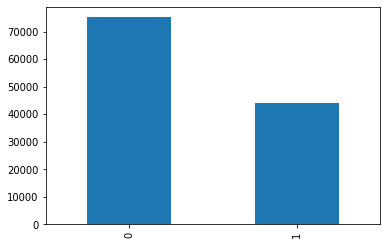

In [11]:
df['is_canceled'].value_counts().plot(kind = 'bar')

We see that the dataset is imbalanced. This forces us to:
- Set `stratify` to `y` while splitting the dataset so that the proportion of `is_canceled = 0`, and `is_canceled = 1` remains constant in the training and test dataset.
- Use metric like f1 score to assess the performance of our model

In [12]:
from sklearn.model_selection import train_test_split


RANDOM_STATE = 7
y= df['is_canceled']
X = df.drop('is_canceled', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = RANDOM_STATE)

## Bagging

### Exercise 1: Training Bagging Classifier
<b><div style="text-align: right">[POINTS: 1]</div></b>

---


**Task:** 
-  Instantiate BaggingClassifier in the variable `bagging` with __n_estimators__ set to 100 and  __random_state__ set to RANDOM_STATE

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import f1_score


bagging = None
### BEGIN SOLUTION
bagging = BaggingClassifier(n_estimators = 100, random_state = RANDOM_STATE)
### END SOLUTION
bagging.fit(X_train, y_train)
print("Train f1_score:", f1_score(y_train, bagging.predict(X_train), average = 'weighted'))
print("Test f1_score:", f1_score(y_test, bagging.predict(X_test), average = 'weighted'))

In [ ]:
assert bagging is not None
### BEGIN HIDDEN TESTS

assert bagging.n_estimators == 100, "Please set the number of estimators to 100"
assert bagging.random_state == RANDOM_STATE, "Please set the random state to RANDOM_STATE"

### END HIDDEN TESTS

## Random Forest

### Exercise 2: Training Random Forest Classifier
<b><div style="text-align: right">[POINTS: 1]</div></b>

---


**Task:** 
-  Instantiate RandomForestClassifier in the variable `rf` with __n_estimators__ set to 100, and  __random_state__ set to RANDOM_STATE

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = None
### BEGIN SOLUTION
rf = RandomForestClassifier(n_estimators = 100, random_state = RANDOM_STATE)
### END SOLUTION
rf.fit(X_train, y_train)
print("Train f1_score:", f1_score(y_train, rf.predict(X_train), average = 'weighted'))
print("Test f1_score:", f1_score(y_test, rf.predict(X_test), average = 'weighted'))

In [ ]:
assert rf is not None
### BEGIN HIDDEN TESTS

assert rf.n_estimators == 100, "Please set the number of estimators to 100"
assert rf.random_state == RANDOM_STATE, "Please set the random state to RANDOM_STATE"

### END HIDDEN TESTS

## XGBoost

### Exercise 3: XGBoost Training
<b><div style="text-align: right">[POINTS: 1]</div></b>

---
Here we will train XGBoost with most of the parameters left to default.

**Task:** 
-  Instantiate XGBClassifier in the variable `xgb` with __n_estimators__ set to 100 and __random_state__ set to RANDOM_STATE


In [ ]:
from xgboost import XGBClassifier


xgb = None
### BEGIN SOLUTION
xgb = XGBClassifier(n_estimators = 100, random_state = RANDOM_STATE)
### END SOLUTION
xgb.fit(X_train, y_train)
print("XGBClassifer with default parameters:\n")
print(xgb)

XGBClassifer with default parameters:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
assert xgb is not None
### BEGIN HIDDEN TESTS

assert xgb.n_estimators == 100, "Please set the number of estimators to 100"
assert xgb.random_state == RANDOM_STATE, "Please set the random state to RANDOM_STATE"

### END HIDDEN TESTS

### Model Evaluation


In [ ]:
print("Train f1_score:", f1_score(y_train, xgb.predict(X_train), average = 'weighted'))
print("Test f1_score:", f1_score(y_test, xgb.predict(X_test), average = 'weighted'))

Train f1_score: 0.8411529574306595
Test f1_score: 0.8421695275032451


### Tree Visualization

### Exercise 4: Plot the tree structure
<b><div style="text-align: right">[UNGRADED]</div></b>

---
Plot the tree structure in the cell below. You can use `plot_tree()` or `to_graphviz()` method provided by xgboost to plot the tree.

**Task:** 
-  Your task is to plot the 20th tree and answer the quiz below.



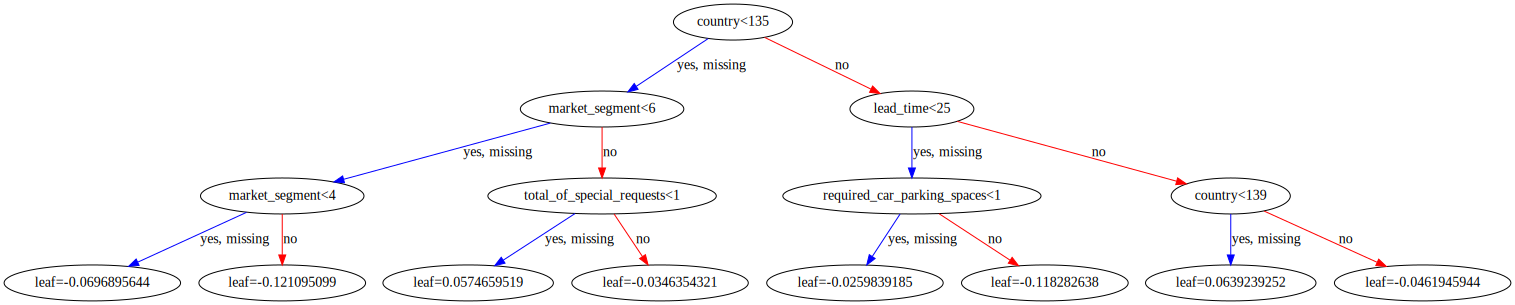

In [ ]:
from xgboost import plot_tree, to_graphviz


# Plot the tree

### BEGIN SOLUTION
to_graphviz(xgb, num_trees = 19)
### END SOLUTION

#### Q1: Based on the tree plotted above, which of the following feature is a root node in the 20th tree?
<b><div style="text-align: right">[UNGRADED]</div></b>

---
Choose from the drop box below.

In [ ]:
### RUN THIS CELL TO ANSWER
%run plot_tree_quiz.py

ERROR:root:File `'plot_tree_quiz.py'` not found.


In [ ]:
assert(plot_tree_quiz.value != None)
# Points allocated : 1
### BEGIN HIDDEN TESTS
assert(plot_tree_quiz.value == 'required_car_parking_spaces')
### END HIDDEN TESTS

NameError: ignored

### Feature importance

### Exercise 5: Plot the feature importance
<b><div style="text-align: right">[UNGRADED]</div></b>

---
XGBoost provides the `feature_importance()` method to plot the importance of each feature. Based on the feature_importance plot, you need to answer the quiz below.

**Task:** 
-  Plot the feature importance of the model `xgb`.



In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,6), dpi=300)
None # plot_importance(.....)
### BEGIN SOLUTION
plot_importance(xgb, ax = ax, importance_type = 'gain')
### END SOLUTION
plt.show()

#### Q2: Based on the gain, which of the following is the most important feature?
<b><div style="text-align: right">[UNGRADED]</div></b>

---
Choose from the drop box below.

In [ ]:
### RUN THIS CELL TO ANSWER
%run plot_importance_quiz.py

In [ ]:
assert(plot_importance_quiz.value != None)
# Points allocated: 1
### BEGIN HIDDEN TESTS
assert(plot_importance_quiz.value == 'deposit_type')
### END HIDDEN TESTS

### Parallelization

### Exercise 6: Multithreading
<b><div style="text-align: right">[UNGRADED]</div></b>

---
As already discussed in the theoretical part, XGBoost is known for parallelization and distributed computing. Here we are going to instantiate XGBoost with its support for multithreading. You can refer to the documentation of XGBoost on how to set the number of threads to the number of cores.

**Task:**  
- Instantiate a XGBClassifier() to variable `model` with __random_state__ set to RANDOM_STATE and set the number of threads to number of cores.



In [ ]:
model = None
### BEGIN SOLUTION
model = XGBClassifier(random_state = RANDOM_STATE, n_jobs = -1)
### END SOLUTION

In [ ]:
### INTENTIONALLY LEFT BLANK
### BEGIN HIDDEN TESTS
assert model.n_jobs == -1, "Set the number of threads to number of cores."
### END HIDDEN TESTS

### Performance Monitoring and learning curve

For performance monitoring, we define a function `learning_curve()` which plots the log loss for each boosting iteration for training and validation dataset. 

Note: Here, test data is used for validation, but it is good practice to have a separate validation set.

In [ ]:
def learning_curve(model, X_train, y_train, X_test, y_test):
    """
    A function to plot the learning curve.
    
    Paramters:
    ---------
    model: object
           An object instantiated with XGBoost classifier
    X_train: array like
             Training features
    y_train: array like
             Training labels
    X_test: array like
            Validation features
    y_test: array like
            Validation labels
            
    Returns:
    --------
    None
    
            
    """
    eval_set = [(X_train, y_train),(X_test, y_test)]
    model.fit(X_train, y_train, eval_metric = ["logloss"], eval_set = eval_set, verbose = False)
    print("F1 Score Train: ",f1_score(y_train, model.predict(X_train), average = 'weighted'))
    print("F1 Score Test: ",f1_score(y_test, model.predict(X_test), average = 'weighted'))
    results = model.evals_result()
    num_tree = len(results['validation_0']['logloss'])
    plt.figure(figsize = (8,8))
    plt.plot(range(0, num_tree), results['validation_0']['logloss'], label = 'Training')
    plt.plot(range(0, num_tree), results['validation_1']['logloss'], label = 'Validation')
    plt.legend()
    plt.xlabel("Number of trees")
    plt.ylabel("Log loss")
    plt.title("Learning Curve")
    plt.show()



### Exercise 7: Learning Curve
<b><div style="text-align: right">[UNGRADED]</div></b>

---
A function `learning_curve()` is defined above. Use this function to plot the learning curve for the training and validation dataset. Here we will be using the test set for validation.
**Task:**  
- Instantiate a XGBClassifier() to variable `model` with __n_estimators__ set to 100 , __max_depth__ set to 4, and __random_state__ set to RANDOM_STATE.
-  Use the function `learning_curve()` to plot the learning curve of the model `xgb`. We have already instantiated `xgb` a few cells back.


In [ ]:
model = None
# Plot learning curve
### BEGIN SOLUTION
model = XGBClassifier(n_estimators = 100, max_depth =4, random_state = RANDOM_STATE)
learning_curve(model, X_train, y_train, X_test, y_test)  
### END SOLUTION

#### Q3: Recalling evaluation results of random forest trained few cells above and analyzing the above learning curve shows that our xgboost model is  ____?
<b><div style="text-align: right">[UNGRADED]</div></b>

---
Choose from the drop box below.

In [ ]:
### RUN THIS CELL TO ANSWER
%run is_overfitted.py

In [ ]:
assert(is_overfitted.value != None)
### BEGIN HIDDEN TESTS
assert(is_overfitted.value == 'underfitted')
### END HIDDEN TESTS

### Exercise 8: Improving performance
<b><div style="text-align: right">[POINTS: 1]</div></b>

---
Based on your answer, if the model is overfitted, under fitted, or optimally fitted, you need to perform a few experiments and improve its performance. The test f1-score of the model should be above 89.00%

Hint: If the model is overfitted, you can perform shrinkage, reduce the depth of the tree, apply regularization, etc. Similarly, if the model is under fitted, you can increase the number of iterations and the tree depth.

**Task:**  
- Instantiate a XGBClassifier() to variable `model` with the parameters you think are suitable for improving performance.
- Note: The test f1 score of your model should be equal or above 0.8900 to get the marks.


In [ ]:
model = None
### BEGIN SOLUTION
# xgb = XGBClassifier(n_estimators = 400, n_jobs = -1, max_depth = 15, gamma = 0.1, min_child_weight = 5, random_state = RANDOM_STATE)
model = XGBClassifier(n_estimators = 400, n_jobs = -1, max_depth = 15, random_state = RANDOM_STATE)
### END SOLUTION
model.fit(X_train, y_train)
pickle.dump(model, open("model.pickle.dat", "wb"))

print("Train f1_score:", f1_score(y_train, model.predict(X_train), average = 'weighted'))
print("Test f1_score:", f1_score(y_test, model.predict(X_test), average = 'weighted'))

In [ ]:
### INTENTIONALLY LEFT BLANK
### BEGIN HIDDEN TESTS
model = pickle.load(open("model.pickle.dat", "rb"))
f1_score_hidden = f1_score(y_test, model.predict(X_test), average = 'weighted')
assert f1_score_hidden >= 0.89, "F1-score on test set is below 0.8900"
### END HIDDEN TESTS

### Model Tuning

A function `tuning_curve()` is defined, which tunes the xgboost . Here `param_name` is the name of the parameter, and `param_range` is the corresponding range of the parameter's value. This function plot the log loss for different value of these parameters. The plot has a vertical line with a central dot corresponding to each value of the parameter.  The vertical length represents the standard deviation of log loss for three cross-fold validation. Similarly, the central dot represents the mean log loss for three cross-fold validation.

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold


def tuning_curve(param_name, param_range):
    """
    A function to perform hyperparameter tuning.
    
    A 3 fold stratified cross validation is performed for each value of parameter.
    
    
    Parameters:
    ----------
    param_name: str
                Name of the parameter on which to perform hyperparamter tuning.
    param_range: list
                 Range of parameter to perform grid search
                 
    Returns:
    -------
    None
    """
    mean = []
    std = []
    for n in param_range:
        arg = dict()
        arg[param_name] = n
        model = XGBClassifier(random_state = RANDOM_STATE,n_jobs = -1,  **arg)
        skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
        scores = cross_validate(model, X_train, y_train, scoring = ['neg_log_loss'], cv = skfold)
        mean_temp = np.abs(scores['test_neg_log_loss']).mean()
        mean.append(mean_temp)
        std_temp = np.abs(scores['test_neg_log_loss']).std()/2.0
        std.append(std_temp)
    plt.errorbar(param_range, mean, std, fmt = 'o') 
    plt.xlabel("{}".format(param_name))
    plt.ylabel("{}".format("Log loss"))
    plt.title("Cross Validation Score")
    plt.show()



### Exercise 9: Tuning L1-Regularization term.
<b><div style="text-align: right">[UNGRADED]</div></b>

---
A function `tuning_curve()` is defined above. Use this function to tune L1 regularization term in the range $[0, 0.4, 1, 5, 10]$

**Task:**  
- Use function `tuning_curve()` to tune the parameter `reg_alpha` in the range $[0, 0.4, 1, 5, 10]$ and answer the following quiz.


In [ ]:
None # Call function tuning_curve() to tune reg_alpha in the given range

### BEGIN SOLUTION
tuning_curve(param_name = 'reg_alpha', param_range = [0, 0.4, 1, 5, 10])  
### END SOLUTION

#### Q4: From the above curve, which of the following value of reg_alpha yields the best performance?
<b><div style="text-align: right">[UNGRADED]</div></b>

---
Choose from the drop box below.


In [ ]:
### RUN THIS CELL TO ANSWER
%run tuning_alpha.py

In [ ]:
assert(tuning_alpha_quiz.value != None)
### BEGIN HIDDEN TESTS
assert(tuning_alpha_quiz.value == '1')
### END HIDDEN TESTS

__Congratulation!!!!!!!!!!!!!__

__You have completed level 1__

## Level 2+3

## Learning Objective (Level2+Level 3)
<b><div style="text-align: right">[POINTS: 6]</div></b>

- Implement Gradient Boosting Regressor from scratch.

- Compare the performance of gradient boosting regressor implement from scratch with Sklearn's gradient boosting regressor.



### Dataset Description

We will use a synthetic dataset for this part. A synthetic dataset is generated using Sklearn's `make_regression()` method.

---
Number of Instances: 100

Number of Attributes:4

---
The features are labeled `x1`, `x2`,`x3`,`x4`, and the output value is labeled `target`.


In [ ]:
from sklearn.datasets import make_regression


RANDOM_STATE = 7
X, y = make_regression(n_samples=100, n_features=4, n_informative=3, bias = 2,noise=0.05, random_state = RANDOM_STATE)
df = pd.DataFrame(X, columns = ['x1', 'x2', 'x3', 'x4'])
df['target']= y
df.head()

### Scatter plot

If you would like, you could visualize the scatter plot of individual features with respect to the target variable. Moreover, if you like to understand better the distribution of the data, you can experiment yourself.

In [ ]:
# Perform experiment to understand data distribution if needed.
plt.scatter(X[:,0], y)
plt.ylabel("Output/independent variable")
plt.xlabel("Input/dependet variable")
plt.show()

### Train Test Split
As usual, we will keep 80% of the data for training and the rest for testing.

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)

## Gradient Boosting Regressor from scratch
In this section, we will implement a gradient boosting regressor from scratch. Each base learner will be a decision tree. For this, we will use Sklearn's `DecisionTreeRegressor()` object.

Here is a pseudo-code for gradient boosting regressor.
```
Algorithm:
```
> 1. initialize $F_0= \frac{1}{N}\sum_{i=1}^N y_i$
2. for $t=1$ to $M$ do
3. > calculate negative gradients $-g(\mathbf{x_i})$; where $-g(\mathbf{x_i})= -\frac{\partial L(y_i, F(\mathbf{x_i}))}{\partial F(\mathbf{x_i})}\bigg{|}_{F = F_{t-1}}$
4. > fit a base-learner model $h$ to negative gradients $-g(\mathbf{x_i})$
5. > update the function: $F_t=F_{t-1} + \alpha h(\mathbf{x})$; where $\alpha$ is a shrinkage
6. end for

Below is a skeleton class for the gradient boosting regressor. We have already defined a constructor for initializing different attributes like `learning_rate`, `max_depth` of each tree, and `n_estimators` for the number of boosting iterations. The attribute `estimators` is a list of each trained base learner.

### Exercise 10: Gradient Boosting Regressor from scratch
<b><div style="text-align: right">[POINTS: 1+3+1]</div></b>

---
This exercise is divided into three different tasks. Through these three tasks, you will create a gradient boosting regressor.

**Task 1: Computation of negative gradient** 
<b><div style="text-align: right">[POINTS: 1]</div></b>

We have defined a static method `negative_gradient` which should return the negative gradient when actual label $y$ and predicted label $\hat{y}$ are given. You need to complete this function.

-  Your task is to assign the negative gradient the the variable `grad`. Suppose we are using the following loss function $$L(y,\hat{y})= \frac{1}{2}(y-\hat{y})^2$$ 
where, $y$ is the actual label and $\hat{y}$ is the predicted label.


**Task 2: Fit the model** 

<b><div style="text-align: right">[POINTS: 3]</div></b>


In this task, we are going to fit our model with the training dataset. We have defined a function `fit(X,y)` in the class `Gradient_Boosting_Regressor` where, X is the training features, and y is the training label. As already discussed in the reading material, the first prediction is the average of output label. Here we have defined two attributes, `average` and `base_prediction`. `base_prediction` is a vector of average value with a length equal to the number of instances in the training data. 


- Compute the negative_gradient using the above defined function and put it in the variable `pseduo_residual`.
- Instantiate a decision tree regressor(from sklearn) on variable `tree` setting `max_depth` to the variable provided in the class constructor and setting `random_state` to RANDOM_STATE.
- Fit the tree on input X and pseudo_residual as a target.
- Update `base_prediction` with the prediction of the current tree. Note: The prediction of each tree should be downscaled by shrinkage. Please replace 0 with your own code.

**Task 3: Prediction by model** 

<b><div style="text-align: right">[POINTS: 1]</div></b>


In this exercise, we are going to make a prediction based on the input data. We have defined a function `predict(X)` in the class `Gradient_Boosting_Regressor` where, X is a feature for which we want to make a prediction. Here we have initialized the variable `predictions` by the average value of the training label. We want to return the final prediction made by the model.


- The average prediction is already assigned to the variable `predictions`. Your task is to add the predictions made by each estimator to the variable `predictions`. Please replace 0 with your code.


The last method, `staged_predict()` is a generator that returns the prediction for each boosting iterations.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

class Gradient_Boosting_Regressor:
    """
    Gradient boosting for regression.
    
    This implementation uses a mean square error loss function.
    
    Parameters:
    ----------
    learning_rate: int
                   Learning rate or shrinkage parameter (the default is 0.1)
    max_depth: int
               Maximum allowed depth for each tree (the default value is 4)
    n_estimators: int
                  The total number of boosting operations (the default value is 5)  
                   
    """
    def __init__(self, learning_rate = 0.1, max_depth = 3, n_estimators = 5):
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.estimators = []
        
        
    @staticmethod
    def negative_gradient(y, y_pred):
        """Compute and return the negative gradient. """
        grad = None
        ### BEGIN SOLUTION
        grad = y-y_pred
        ### END SOLUTION
        return grad
    
    
    def fit(self, X, y):
        """Fit the model on data X and y"""
        self.average = np.mean(y)
        self.base_prediction = np.array([np.mean(y)]*len(y))
        
        for estimators in range(self.n_estimators):
            pseudo_residuals = None
            tree = None 
            None # tree.fit(...)
            self.base_prediction += 0 # None ########### WHAT IS THE USE OF THIS LINE?
            ### BEGIN SOLUTION
            pseudo_residuals = self.negative_gradient(y, self.base_prediction)
            tree = DecisionTreeRegressor(max_depth = self.max_depth, random_state = 7)
            tree.fit(X, pseudo_residuals)
            self.base_prediction += self.learning_rate*tree.predict(X)            
            ### END SOLUTION
            self.estimators.append(tree)
            
            
    def predict(self, X):
        """Make prediction by the model on data X."""
        predictions = np.array([self.average]*X.shape[0])
        for estimator in self.estimators:
            predictions += 0 # None
            ### BEGIN SOLUTION
            predictions += self.learning_rate*estimator.predict(X)
            ### END SOLUTION
        return predictions
    
    
    def staged_predict(self, X):
        """A generator which returns the prediction at each boosting iteration."""
        predictions = np.array([self.average]*X.shape[0])
        
        for estimator in self.estimators:
            predictions += self.learning_rate*estimator.predict(X)
            yield predictions

        

In [ ]:
assert Gradient_Boosting_Regressor().negative_gradient(y_train, y_train+1) is not None
### BEGIN HIDDEN TESTS
y_hidden_true = np.array([1.4, 2.0, 3.3, 9.1, 3.4])
y_hidden_pred = np.array([0.0, 1.1, 2.4, 4.7, 8.4])
gradient_hidden = (y_hidden_true - y_hidden_pred)
gradient_hidden_by_student = Gradient_Boosting_Regressor().negative_gradient(y_hidden_true, y_hidden_pred)
np.testing.assert_equal(gradient_hidden, gradient_hidden_by_student, err_msg = "Please check the function negative_gradient().")
### END HIDDEN TESTS

In [ ]:
model = Gradient_Boosting_Regressor()
model.fit(X_train, y_train)
assert not np.array_equal(model.predict(X_train), np.array([np.mean(y_train)]*len(y_train))), "Make sure you have implemented the code for fit and predict methods."
### BEGIN HIDDEN TESTS

class Gradient_Boosting_Regressor:
    """
    Gradient boosting for regression.
    
    This implementation uses mean square error loss function.
    
    Parameters:
    ----------
    learning_rate: int
                   Learning rate or shrinkage parameter (the default is 0.1)
    max_depth: int
               Maximum allowed depth for each tree (the default value is 4)
    n_estimators: int
                  The total number of boosting operations (the default value is 5)  
                   
    """
    def __init__(self, learning_rate =0.1, max_depth = 3, n_estimators = 5):
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.estimators = []
        
        
    @staticmethod
    def negative_gradient(y, y_pred):
        """Compute and returns the negative gradient. """
        grad = y-y_pred
        return grad
    
    
    def fit(self, X, y):
        """Fit the model"""
        self.average = np.mean(y)
        self.base_prediction = np.array([np.mean(y)]*len(y))
        
        for estimators in range(self.n_estimators):
            pseudo_residuals = self.negative_gradient(y, self.base_prediction)
            
            tree = DecisionTreeRegressor(max_depth = self.max_depth, random_state = 7)
            tree.fit(X, pseudo_residuals)
            self.base_prediction += self.learning_rate*tree.predict(X)
            self.estimators.append(tree)
            
            
    def predict(self, X):
        """Make prediction by the model for input data X."""
        predictions = np.array([self.average]*X.shape[0])
        
        for estimator in self.estimators:
            predictions += self.learning_rate*estimator.predict(X)
        return predictions
    
    
    def staged_predict(self, X):
        """A generator which returns the prediction at each boosting iteration."""
        predictions = np.array([self.average]*X.shape[0])
        
        for estimator in self.estimators:
            predictions += self.learning_rate*estimator.predict(X)
            yield predictions

teacher = Gradient_Boosting_RegressorT()
student = Gradient_Boosting_Regressor()
teacher.fit(X_train[:20, :], y_train[:20])
teacher_prediction_hidden = teacher.predict(X_train[:20, :])

student.fit(X_train[:20, :], y_train[:20])
student_prediction_hidden = student.predict(X_train[:20, :])

# np.testing.assert_almost_equal(teacher_prediction_hidden, student_prediction_hidden, decimal = 3,  err_msg = "Please check either fit or predict method" )
### END HIDDEN TESTS

## Evaluation and Comparision
In this and coming sections, we will first evaluate the gradient boosting regressor that we just built from scratch and then compare it with the Sklearn's gradient boosting regressor.

Let's see how our model has performed.

In [ ]:
from sklearn.metrics import r2_score

custom_gbm = Gradient_Boosting_Regressor(learning_rate = 0.2, max_depth = 3, n_estimators = 4)
custom_gbm.fit(X_train, y_train)


print("r2_score:", r2_score(y_test, custom_gbm.predict(X_test)))

### Visualization
Let's see if the prediction gets improved with the added estimators. Here we will plot the actual and predicted target value.

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (20,4.5), sharex = True)
fig.suptitle("Prediction made by our custom gradient boosting regressor")
for i, pred in enumerate(custom_gbm.staged_predict(X_test)):
    ax[i].scatter(y_test, pred, marker = 'o')
    ax[i].set_title("n_estimators={}; r2_score={:04.2f}".format(i+1, r2_score(y_test, pred)))
    ax[i].set_xlabel("Actual value")
    ax[i].set_ylabel("Predicted value")
plt.show()

#### Q5: With our custom gradient boosting regressor, the prediction has ______ with boosting iteration?
<b><div style="text-align: right">[UNGRADED]</div></b>

---
Choose from the drop box below to fill in the blank.

In [ ]:
### RUN THIS CELL TO ANSWER
%run custom_performance.py

In [ ]:
assert(custom_performance.value != None)

### BEGIN HIDDEN TESTS
assert(custom_performance.value == 'improved')
### END HIDDEN TESTS

### Gradient Boosting Regressor in sklearn
Let's see how our model compared with the gradient boosting regressor in sklearn.

### Exercise 11: Training Sklearn's GradientBoostingRegressor

---
<b><div style="text-align: right">[POINTS: 1]</div></b>

In this exercise, we are going to train Sklearn's GradientBoostingRegressor.

**Task:** 
- Create an object `gbm` of the `GradientBoostingRegressor` class setting criterion to `mse`, n_estimators to 4, max_depth to 3, learning_rate to 0.2 and random_state to RANDOM_STATE.
- Fit the object on the training set `X_train`, and `y_train`.



In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = None
# Fit the model 
### BEGIN SOLUTION
gbm = GradientBoostingRegressor(criterion = 'mse', n_estimators = 4, max_depth = 3, learning_rate = 0.2, random_state = 7)
gbm.fit(X_train, y_train)

### END SOLTUION
print("r2_score: ", r2_score(y_test, gbm.predict(X_test)))

In [ ]:
assert gbm is not None
### BEGIN HIDDEN TESTS
from sklearn.exceptions import NotFittedError


assert gbm.criterion == 'mse', "Please set the criterion to mse"
assert gbm.n_estimators == 4, "Please set the number of estimators to 4"
assert gbm.learning_rate ==0.2, "Please set the learning rate to 0.2"
assert gbm.random_state == RANDOM_STATE, "Please set the random state to RANDOM_STATE"

try:
    gbm.predict(X_test)
except NotFittedError as e:
    raise "Model is not fitted"
### END HIDDEN TESTS

### Visualization
Let's visualize how the prediction made by Sklearn's gradient boosting regressor looks.

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (20,5), sharex = True, sharey=True)
fig.suptitle("Prediction made by sklearn's gradient boosting regressor")
for i, pred in enumerate(gbm.staged_predict(X_test)):
    ax[i].scatter(y_test, pred, marker = 'o')
    ax[i].set_title("n_estimators={}; r2_score={:04.2f}".format(i+1, r2_score(y_test, pred)))
    ax[i].set_xlabel("Actual value")
    ax[i].set_ylabel("Predicted value")
plt.show()

#### Q6: Based on the above two plots, the performance of Sklearn's gradient boosting regressor is ______ our custom gradient boosting regressor?
<b><div style="text-align: right">[UNGRADED]</div></b>

---
Choose from the drop box below to fill in the blank.

In [ ]:
### RUN THIS CELL TO ANSWER
%run performance_compare1.py

In [ ]:
assert(performance_compare1.value != None)
### BEGIN HIDDEN TESTS
assert(performance_compare1.value == 'same as')
### END HIDDEN TESTS

### Loss vs. boosting iterations
We will plot the value of mse loss at different iterations to visualize how the model's performance has improved. The function `learning_curve()` plots the mse of training and test data at each boosting iteration.

In [ ]:
from sklearn.metrics import mean_squared_error as mse


def learning_curve(clf):
    train_mse = []
    test_mse = []
    for pred in clf.staged_predict(X_train):
        train_mse.append(mse(y_train, pred))
    for pred in clf.staged_predict(X_test):
        test_mse.append(mse(y_test, pred))
    plt.plot(np.arange(clf.n_estimators)+1, train_mse, 'r', label= "Training")
    plt.plot(np.arange(clf.n_estimators)+1, test_mse, 'b', label = "Testing")
    plt.xlabel("Iterations")
    plt.ylabel("MSE loss")
    plt.legend()
    plt.show()

In [ ]:
custom_clf = Gradient_Boosting_Regressor(n_estimators = 100, max_depth = 1, learning_rate = 0.1)
custom_clf.fit(X_train, y_train)
learning_curve(custom_clf)
print("MSE:" ,mse(y_test, custom_clf.predict(X_test)))
print("r2_score" ,r2_score(y_test, custom_clf.predict(X_test)))

In [ ]:
clf = GradientBoostingRegressor(n_estimators = 100, max_depth = 1, learning_rate = 0.1, criterion = 'mse')
clf.fit(X_train, y_train)
learning_curve(clf)
print("MSE:", mse(y_test, clf.predict(X_test)))
print("r2_score", r2_score(y_test, clf.predict(X_test)))

#### Q7: Based on the learning curve, the performance of Sklearn's gradient boosting regressor is ______ our custom gradient boosting regressor?
<b><div style="text-align: right">[UNGRADED]</div></b>

---
Choose from the drop box below to fill in the blank.

In [ ]:
### RUN THIS CELL TO ANSWER
%run performance_compare2.py

In [ ]:
assert(performance_compare2.value != None)
### BEGIN HIDDEN TESTS
assert(performance_compare2.value == 'same as')
### END HIDDEN TESTS

__Congratulation!!!!!!!!!!!!!__

__You have completed the assignment__